In [1]:
import sys
sys.path.insert(0, "/Users/alexanderholstrup/git/VisualPlaceRecognition/cnnimageretrieval-pytorch")

[0.548364846401605]


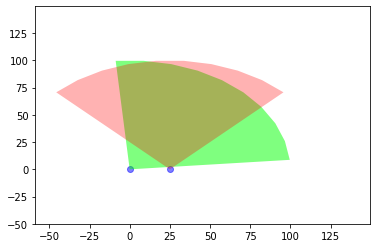

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from os.path import join
import torch
from PIL import Image
import cv2 as cv
from cirtorch.utils.view_angle import field_of_view, ious

In [3]:
def convert_path(idx):
    return f'{root}/{idx[5:]}'

def distance(query, positive):
    return torch.norm(query - positive, dim=-1)

def ioudistance(query, positive):
    pol = field_of_view([query, positive])
    return ious(pol[0], pol[1:])[0]
    

In [4]:
default_cities = {
    'train': ["london", "zurich", "boston", "melbourne", "amsterdam","helsinki",
              "tokyo","toronto","saopaulo","moscow","trondheim","paris","bangkok",
              "budapest","austin","berlin","ottawa","phoenix","goa","amman","nairobi","manila"],
    'val': ["cph", "sf"],
    'test': ["miami","athens","buenosaires","stockholm","bengaluru","kampala"]
}
root = '/Users/alexanderholstrup/git/VisualPlaceRecognition/cnnimageretrieval-pytorch/notebooks/data/IT5/MSEAndContrastive400/Train/Images' #

dataset_path = '/Users/alexanderholstrup/Desktop/datasets/tuples/val'

qpool = torch.from_numpy(np.loadtxt(
        f'{dataset_path}/qpool.txt', delimiter=','))
ppool = torch.from_numpy(np.loadtxt(
        f'{dataset_path}/ppool.txt', delimiter=','))

qcoordinates = torch.from_numpy(np.loadtxt(
        f'{dataset_path}/qcoordinates.txt', delimiter=','))
pcoordinates = torch.from_numpy(np.loadtxt(
        f'{dataset_path}/dbcoordinates.txt', delimiter=','))
    
qimages = pd.read_csv(f'{dataset_path}/qImages.txt', delimiter=',', header=None)
dbimages = pd.read_csv(f'{dataset_path}/dbImages.txt', delimiter=',', header=None)


data/train_val/sf/query/images/1QG2xFymrtxTNzppEqQFew.jpg


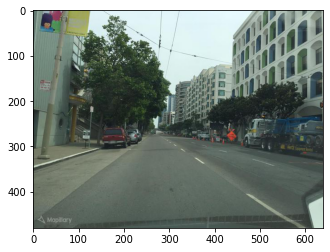

data/train_val/sf/database/images/icz0vNQqvH6KA0GZ8CmUw9.jpg


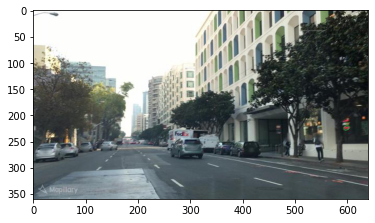

data/train_val/sf/database/images/XYAICRx859ziuAbB_EkI-h.jpg


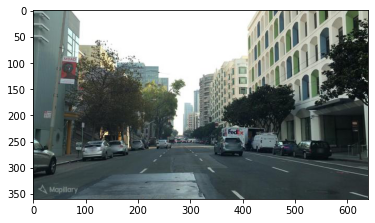

data/train_val/sf/database/images/xB98UTLSD3Kc7gpGqNcAPm.jpg


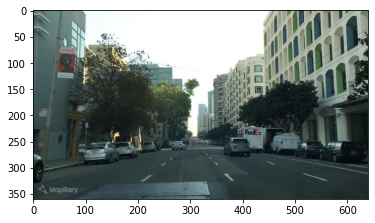

data/train_val/sf/database/images/45fgUjdT2vqQnGecHwBPej.jpg


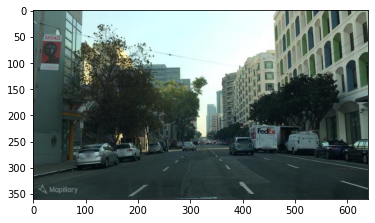

data/train_val/sf/database/images/8hdKQ1yLnawlndB-NZQRDf.jpg


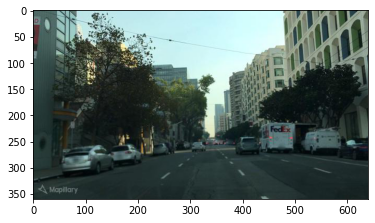

data/train_val/sf/database/images/CvCeaVwYYuzTV6D3P9MObt.jpg


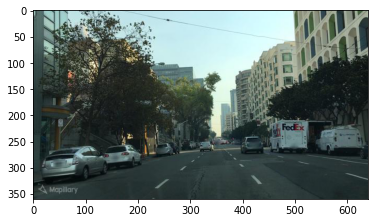

data/train_val/sf/database/images/81uf2DZ3aTIHBin4Abw58W.jpg


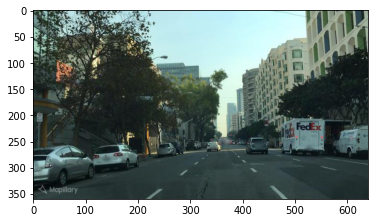

data/train_val/sf/database/images/A96U73t4ZogemCLEfvd5MW.jpg


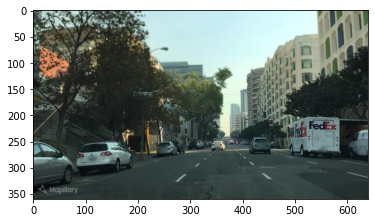

data/train_val/sf/database/images/TYefYJtTx5KfjmpW5JK-0l.jpg


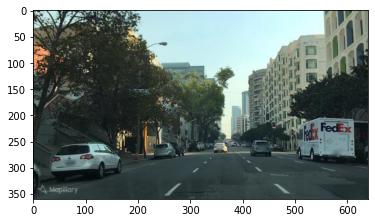

data/train_val/sf/database/images/YtWhej2t0v0heoo8TJw1vX.jpg


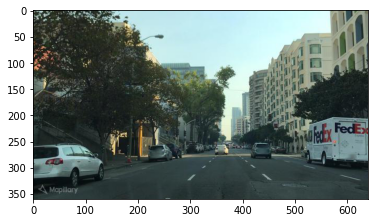

In [5]:
qimages.iloc[[q]]
print(qimages.iloc[[q]].values[0][0])


pil_im = Image.open(convert_path(qimages.iloc[[q]].values[0][0]), 'r')
plt.imshow(np.asarray(pil_im))
plt.show()
for p in ps[0:10]:
    idx = dbimages.iloc[[p]].values[0][0]
    pil_im = Image.open(convert_path(idx), 'r')
    plt.imshow(np.asarray(pil_im))
    print(idx)
    plt.show()

In [75]:
i = 49
q = qpool[i]
ps = ppool[i][ppool[i] != -1]
print(q, ps)

tensor(49., dtype=torch.float64) tensor([1335., 1336., 1337., 1338., 1339., 1340., 1341., 1342., 1343., 1344.,
        1345., 1346., 1347., 1348., 1349.], dtype=torch.float64)


In [76]:
#ious_dist = []
q_coor = qcoordinates[int(qpool[i])]
for pos in ppool[int(i)][ppool[int(i)] != -1.0]:
    p_coor = pcoordinates[int(pos)]
    ious_dist.append(ioudistance(q_coor, p_coor))
    #print(ioudistance(q_coor, p_coor))

In [77]:
N = len(ppool[int(i)][ppool[int(i)] != -1.0])
#good_matches = []
for i in range(N):
    p = ps[i]

    queryImage = convert_path(qimages.iloc[[q]].values[0][0])
    trainImage = convert_path(dbimages.iloc[[p]].values[0][0])

    MIN_MATCH_COUNT = 10
    img1 = cv.imread(queryImage,0)          # queryImage
    img2 = cv.imread(trainImage,0) # trainImage
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    good_matches.append(len(good))
    #print(len(good))

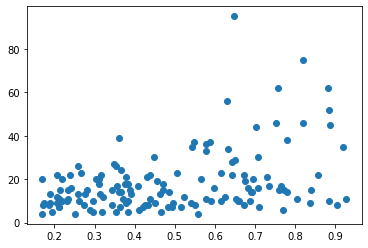

In [78]:
plt.scatter(ious_dist, good_matches)
plt.show()

In [10]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,50.0)
    print(M)
    matchesMask = mask.ravel().tolist()
    
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

[[-2.33629639e-01 -8.91425786e-01  3.07597235e+02]
 [-1.52688262e-01  3.10142223e-02  8.75426294e+01]
 [-1.09252626e-03 -2.00187817e-03  1.00000000e+00]]


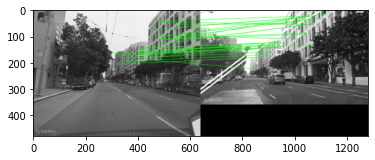

(<matplotlib.image.AxesImage at 0x7f803b472160>, None)

In [9]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

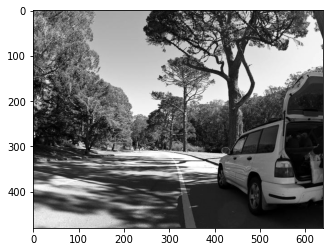

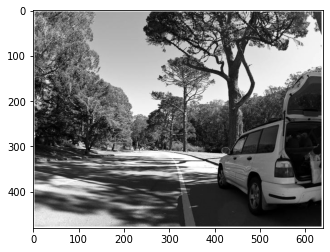

In [35]:
plt.imshow(img1, 'gray')
plt.show()
plt.imshow(img2, 'gray')
plt.show()